In [13]:
#!pip install pytorch-model-summary torchvision

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from pytorch_model_summary import summary

from google.colab import files
import os
import kagglehub

import zipfile
import glob

In [14]:
path = kagglehub.dataset_download("jeffheaton/iris-computer-vision")
print("Path:", path)
print("Содержимое до распаковки:", os.listdir(path))


Using Colab cache for faster access to the 'iris-computer-vision' dataset.
Path: /kaggle/input/iris-computer-vision
Содержимое до распаковки: ['iris-setosa', 'iris-versicolour', 'iris-virginica']


In [15]:
for z in glob.glob(os.path.join(path, "*.zip")):
    print("Распаковываю:", z)
    with zipfile.ZipFile(z, "r") as f:
        f.extractall(path)

print("Содержимое после распаковки:", os.listdir(path))

data_root = os.path.join(path, "iris_photos")
print("data_root =", data_root, "->", os.path.isdir(data_root))


Содержимое после распаковки: ['iris-setosa', 'iris-versicolour', 'iris-virginica']
data_root = /kaggle/input/iris-computer-vision/iris_photos -> False


In [19]:
IMG_SIZE = 64
IMG_CHANNELS = 3
D = IMG_SIZE * IMG_SIZE * IMG_CHANNELS
L = 32
M = 512

lr = 1e-3
num_epochs = 200
max_patience = 15
likelihood_type = 'bernoulli'

data_root = "/kaggle/input/iris-computer-vision"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = datasets.ImageFolder(root=data_root, transform=transform)
print("Всего картинок:", len(full_dataset))

n_total = len(full_dataset)
n_test = int(0.15 * n_total)
n_val = int(0.15 * n_total)
n_train = n_total - n_val - n_test

train_ds, val_ds, test_ds = random_split(
    full_dataset,
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)
)

Всего картинок: 421


In [20]:
# Обёртка, чтобы возвращать только x и сразу флаттировать в вектор длины D
class FlattenDataset(Dataset):
    def __init__(self, base_dataset):
        self.base = base_dataset

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        sample = self.base[idx]
        # ImageFolder / Subset -> (image, label)
        if isinstance(sample, tuple):
            x, _ = sample
        else:
            x = sample
        x = x.view(-1).float()  # [D]
        return x

train_data = FlattenDataset(train_ds)
val_data = FlattenDataset(val_ds)
test_data = FlattenDataset(test_ds)

training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Функции лог распределений

In [21]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_bernoulli(x, p, reduction=None, dim=None):
    pp = torch.clamp(p, EPS, 1. - EPS)
    log_p = x * torch.log(pp) + (1. - x) * torch.log(1. - pp)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D_dim = x.shape[1]
    log_p = -0.5 * D_dim * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu) ** 2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

def log_standard_normal(x, reduction=None, dim=None):
    D_dim = x.shape[1]
    log_p = -0.5 * D_dim * torch.log(2. * PI) - 0.5 * x ** 2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

Encoder - Decoder - Prior - VAE (адаптация под картинки)

In [22]:
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()
        self.encoder = encoder_net

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + std * eps

    def encode(self, x):
        # x: [B, D]
        h_e = self.encoder(x)
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)
        return mu_e, log_var_e

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
            mu_e, log_var_e = self.encode(x)
        else:
            if (mu_e is None) or (log_var_e is None):
                raise ValueError('mu and log-var can`t be None!')
        z = self.reparameterization(mu_e, log_var_e)
        return z

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
            if (mu_e is None) or (log_var_e is None) or (z is None):
                raise ValueError('mu, log-var and z can`t be None!')

        return log_normal_diag(z, mu_e, log_var_e)

    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)

class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution='categorical', num_vals=None):
        super(Decoder, self).__init__()
        self.decoder = decoder_net
        self.distribution = distribution
        self.num_vals = num_vals

    def decode(self, z):
        h_d = self.decoder(z)

        if self.distribution == 'categorical':
            b = h_d.shape[0]
            d = h_d.shape[1] // self.num_vals
            h_d = h_d.view(b, d, self.num_vals)
            mu_d = torch.softmax(h_d, 2)
            return [mu_d]

        elif self.distribution == 'bernoulli':
            #   h_d имеет форму [B, D]
            mu_d = torch.sigmoid(h_d)
            return [mu_d]

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

    def sample(self, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            b = mu_d.shape[0]
            m = mu_d.shape[1]
            p = mu_d.view(-1, self.num_vals)
            x_new = torch.multinomial(p, num_samples=1).view(b, m)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]
            # Для красоты  возвращается НЕ бинарные сэмплы, а среднее,
            # чтобы изображения были плавными (float в [0,1])
            x_new = mu_d

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return x_new

    def log_prob(self, x, z):
        outs = self.decode(z)

        if self.distribution == 'categorical':
            mu_d = outs[0]
            log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)

        elif self.distribution == 'bernoulli':
            mu_d = outs[0]        # [B, D]
            log_p = log_bernoulli(x, mu_d, reduction='sum', dim=-1)

        else:
            raise ValueError('Either `categorical` or `bernoulli`')

        return log_p

    def forward(self, z, x=None, type='log_prob'):
        assert type in ['decoder', 'log_prob'], 'Type could be either decode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x, z)
        else:
            return self.sample(z)

class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        return log_standard_normal(z)

class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals=1, L=32, likelihood_type='bernoulli'):
        super(VAE, self).__init__()
        print('VAE for Iris flowers.')

        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)

        self.num_vals = num_vals
        self.likelihood_type = likelihood_type
        self.L = L

    def forward(self, x, reduction='avg'):
        # encoder
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        RE = self.decoder.log_prob(x, z)  #
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)

        if reduction == 'sum':
            return -(RE + KL).sum()
        else:
            return -(RE + KL).mean()

    def sample(self, batch_size=16):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)

Строю encoder / decoder сети (MLP)

In [23]:
if likelihood_type == 'categorical':
    num_vals = 256
elif likelihood_type == 'bernoulli':
    num_vals = 1

encoder = nn.Sequential(
    nn.Linear(D, M),
    nn.LeakyReLU(),
    nn.Linear(M, M),
    nn.LeakyReLU(),
    nn.Linear(M, 2 * L)
)

decoder = nn.Sequential(
    nn.Linear(L, M),
    nn.LeakyReLU(),
    nn.Linear(M, M),
    nn.LeakyReLU(),
    nn.Linear(M, num_vals * D)
)

model = VAE(encoder_net=encoder, decoder_net=decoder, num_vals=num_vals, L=L, likelihood_type=likelihood_type)

print("ENCODER:\n", summary(encoder, torch.zeros(1, D), show_input=False, show_hierarchical=False))
print("\nDECODER:\n", summary(decoder, torch.zeros(1, L), show_input=False, show_hierarchical=False))


VAE for Iris flowers.
ENCODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 512]       6,291,968       6,291,968
       LeakyReLU-2            [1, 512]               0               0
          Linear-3            [1, 512]         262,656         262,656
       LeakyReLU-4            [1, 512]               0               0
          Linear-5             [1, 64]          32,832          32,832
Total params: 6,587,456
Trainable params: 6,587,456
Non-trainable params: 0
-----------------------------------------------------------------------

DECODER:
 -----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1            [1, 512]          16,896          16,896
       LeakyReLU-2            [1, 512]               0               0
          Linear-3        

функции обучения оценки и визуализации

In [35]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    if model_best is None:
        model_best = torch.load(name + '.model', weights_only=False)

    model_best.eval()
    loss = 0.
    N = 0.
    with torch.no_grad():
        for indx_batch, test_batch in enumerate(test_loader):
            loss_t = model_best.forward(test_batch, reduction='sum')
            loss += loss_t.item()
            N += test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss:.4f}')
    else:
        print(f'Epoch: {epoch}, val nll={loss:.4f}')

    return loss

def samples_real(name, test_loader):
    # Берём один батч реальных картинок
    x = next(iter(test_loader)).detach().numpy()  # [B, D]

    num_x = 4
    num_y = 4
    fig, ax = plt.subplots(num_x, num_y, figsize=(6, 6))
    for i, ax_ in enumerate(ax.flatten()):
        if i >= x.shape[0]:
            break
        img = x[i].reshape(IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        img = np.transpose(img, (1, 2, 0))
        ax_.imshow(img)
        ax_.axis('off')

    plt.tight_layout()
    plt.show()

def samples_generated(name, data_loader, extra_name=''):
    # Берём лучшую модель из файла
    model_best = torch.load(name + '.model', weights_only=False)
    model_best.eval()

    num_x = 4
    num_y = 4
    with torch.no_grad():
        x_gen = model_best.sample(num_x * num_y).detach().numpy()  # [B, D]

    fig, ax = plt.subplots(num_x, num_y, figsize=(6, 6))
    for i, ax_ in enumerate(ax.flatten()):
        img = x_gen[i].reshape(IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        img = np.clip(img, 0, 1)
        img = np.transpose(img, (1, 2, 0))
        ax_.imshow(img)
        ax_.axis('off')

    plt.tight_layout()
    plt.show()

def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth=3)
    plt.xlabel('epochs')
    plt.ylabel('val nll')
    plt.grid(True)
    plt.show()

def plot_reconstructions(name, data_loader, num_images=8):
    model_best = torch.load(name + '.model', weights_only=False)
    model_best.eval()

    x = next(iter(data_loader))
    x_np = x.detach().numpy()

    with torch.no_grad():
        mu_e, log_var_e = model_best.encoder.encode(x)
        z = model_best.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)
        outs = model_best.decoder.decode(z)
        x_rec = outs[0].detach().numpy()

    num_images = min(num_images, x_np.shape[0])
    fig, axes = plt.subplots(2, num_images, figsize=(2 * num_images, 4))

    for i in range(num_images):
        img_real = x_np[i].reshape(IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        img_real = np.transpose(img_real, (1, 2, 0))
        axes[0, i].imshow(np.clip(img_real, 0, 1))
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Real")

        img_rec = x_rec[i].reshape(IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
        img_rec = np.transpose(img_rec, (1, 2, 0))
        axes[1, i].imshow(np.clip(img_rec, 0, 1))
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Recon")

    plt.tight_layout()
    plt.show()

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1e9
    patience = 0

    for e in range(num_epochs):
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0


                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience += 1

        if patience > max_patience:
            print("Early stopping.")
            break

    return np.asarray(nll_val)

In [25]:
#Обучение
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad],
    lr=lr
)

nll_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader
)

test_loss = evaluation(test_loader=test_loader, name=result_dir + name)
with open(result_dir + name + '_test_loss.txt', "w") as f:
    f.write(str(test_loss))

Epoch: 0, val nll=7900.6463
saved!
Epoch: 1, val nll=7750.6052
saved!
Epoch: 2, val nll=7689.6386
saved!
Epoch: 3, val nll=7613.9152
saved!
Epoch: 4, val nll=7576.4097
saved!
Epoch: 5, val nll=7572.7155
saved!
Epoch: 6, val nll=7574.0164
Epoch: 7, val nll=7537.7924
saved!
Epoch: 8, val nll=7528.4541
saved!
Epoch: 9, val nll=7530.9710
Epoch: 10, val nll=7525.7183
saved!
Epoch: 11, val nll=7505.9712
saved!
Epoch: 12, val nll=7509.0704
Epoch: 13, val nll=7510.4472
Epoch: 14, val nll=7523.9588
Epoch: 15, val nll=7495.8418
saved!
Epoch: 16, val nll=7484.5268
saved!
Epoch: 17, val nll=7482.3752
saved!
Epoch: 18, val nll=7484.9742
Epoch: 19, val nll=7465.0950
saved!
Epoch: 20, val nll=7462.5404
saved!
Epoch: 21, val nll=7460.3108
saved!
Epoch: 22, val nll=7465.8003
Epoch: 23, val nll=7428.3738
saved!
Epoch: 24, val nll=7428.5305
Epoch: 25, val nll=7439.5813
Epoch: 26, val nll=7446.5084
Epoch: 27, val nll=7448.9844
Epoch: 28, val nll=7416.5848
saved!
Epoch: 29, val nll=7418.1069
Epoch: 30, val

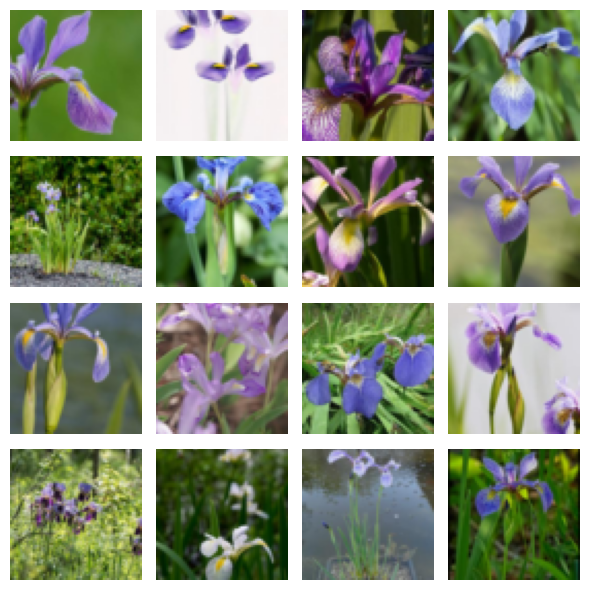

In [31]:
# реальные картинки
samples_real(result_dir + name, test_loader)


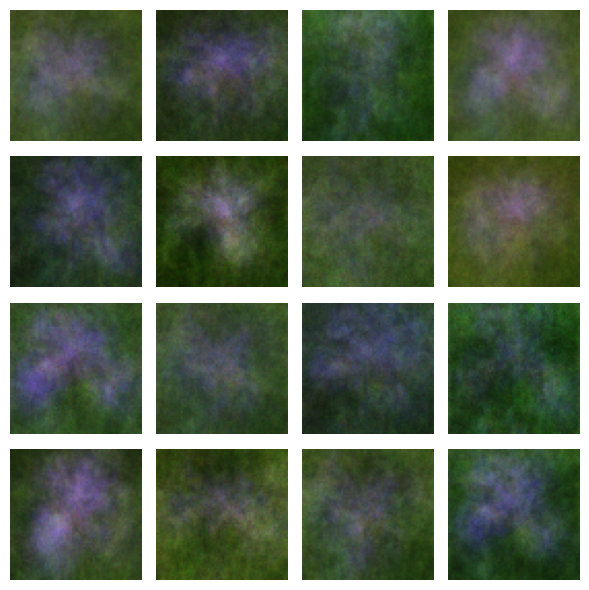

In [32]:
# сгенерированные картинки
samples_generated(result_dir + name, test_loader)

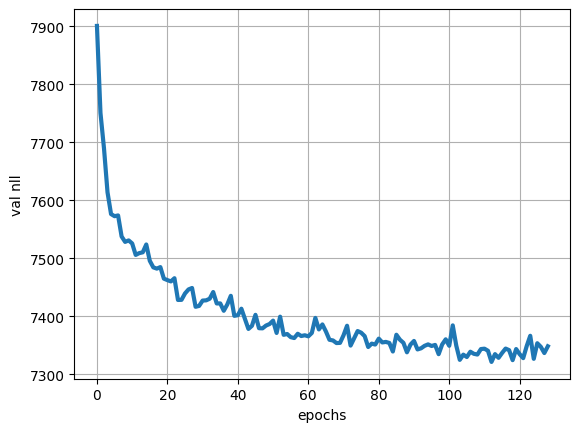

In [33]:
# кривая валидационной NLL
plot_curve(result_dir + name, nll_val)


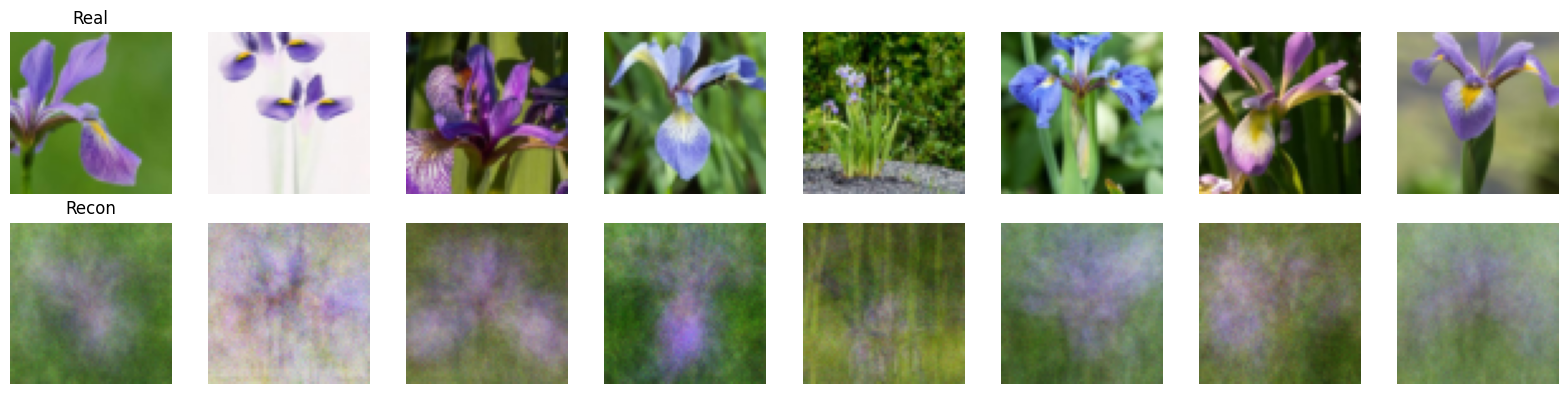

In [36]:
plot_reconstructions(result_dir + name, test_loader)

Модель VAE в целом обучилась - по кривой валидационной NLL видно как сильно снижается лосс а затем в конц еколеблится около одного уровня.

На визуализации видно что модель в целом улавливает общую структуру и уветовые пятница, подобную размытость можно обьяснить простой MLP архитектуры с довольно небольшим латентным размером и сложным цветным изображением: модель хорошо выучила средний образ цветка, но пока плохо передаёт резкие контуры и мелкие детали.
Поэтому для более качественных картинок имело бы смысл использовать сверточный энкодер-декодер или увеличить размер латентного пространства.
